In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
from scipy.cluster.vq import kmeans,vq
from scipy.cluster.hierarchy import fcluster,linkage
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv('Train.csv')
df_test=pd.read_csv('Test.csv')
df_pred=pd.DataFrame()
df_both=pd.concat([df,df_test], ignore_index=True)

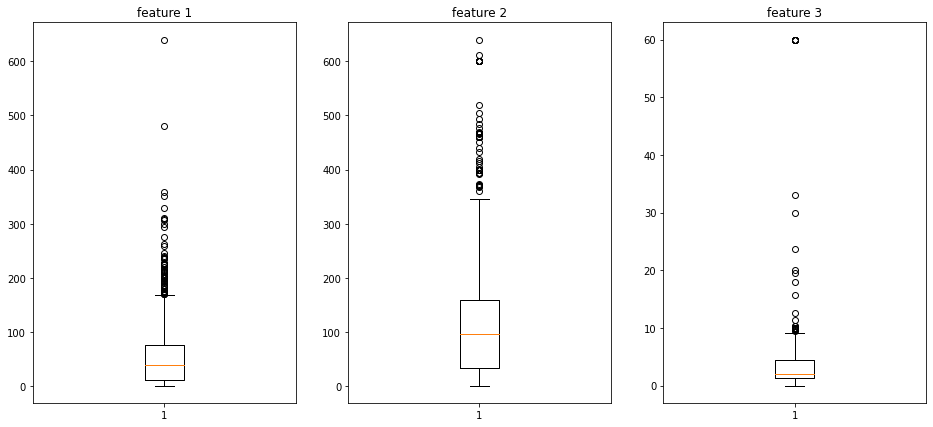

In [3]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df[f'feature_{i+1}'])

In [4]:
for col in df.columns[:3]:
    l=0.1 if col=='feature_2' else 0.05
    df[col]=winsorize(df[col],limits=l)

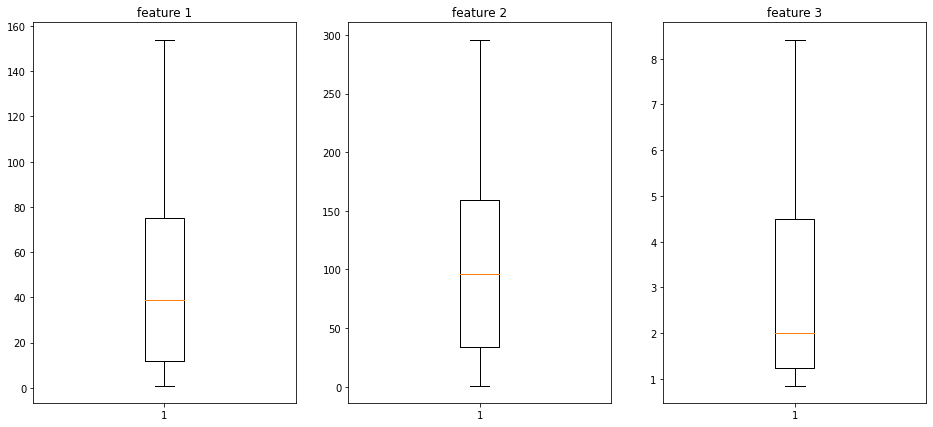

In [5]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df[f'feature_{i+1}'])

In [6]:
df2=pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:3]),columns=df.columns[:3])
df=pd.concat([df2,df.iloc[:,3:]],axis=1)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,1.078244,0.536706,-0.617120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.657223,-0.302744,0.401092,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1.056550,0.427686,-0.651021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.223356,-0.771527,-0.856700,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.830770,1.343449,2.104740,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-1.069396,-1.196703,-0.457401,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,-0.223356,0.972783,0.740496,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,0.991470,1.169018,-0.349271,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,-0.743996,-0.324548,0.765452,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.Class.value_counts()

0    1620
1     143
Name: Class, dtype: int64

In [8]:
def over_sample_train_test(x,y):
    ros=RandomOverSampler(random_state=0)
    ros.fit(x,y)
    x_res,y_res=ros.fit_resample(x,y)
    x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.2,random_state = 1)
    return x_train,x_test,y_train,y_test

x=df.drop('Class',axis=1)
y=df.Class
x_train,x_test,y_train,y_test=over_sample_train_test(x,y)

In [9]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2592, 1558), (648, 1558), (2592,), (648,))

In [10]:
lr=LogisticRegression(solver='liblinear')    
svm=SVC(probability=True)
dt=DecisionTreeClassifier(max_depth=10,max_features=8,random_state=100)
rf=RandomForestClassifier(max_depth=4, max_features=3)
knn=KNeighborsClassifier(n_neighbors=94)
gnb=GaussianNB()
xgb=xgb=XGBClassifier(use_label_encoder=False,random_state=42,eval_metric='mlogloss')

In [11]:
def apply_model(model,x_train,x_test,y_train,y_test):
    print(' '*20+re.search(r'(.*)\(',f'''{model}''',re.M).group(1))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('')
    print('Train Score:  ',model.score(x_train,y_train))
    print('Test Score:   ',model.score(x_test,y_test))
    print('')
    #plot_confusion_matrix(model, x_test, y_test)
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
    print(classification_report(y_test,y_pred))

d={}
def predict_test(model):
    col=re.search(r'(.*)\(',f'''{model}''',re.M).group(1)
    if col not in d:
        d[col]=1
    else:
        d[col]+=1
    col+=f'{d[col]}'
    df_pred[col]=model.predict(df_test)
    df_pred

                    LogisticRegression

Train Score:   0.9521604938271605
Test Score:    0.9320987654320988

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       328
           1       0.93      0.93      0.93       320

    accuracy                           0.93       648
   macro avg       0.93      0.93      0.93       648
weighted avg       0.93      0.93      0.93       648



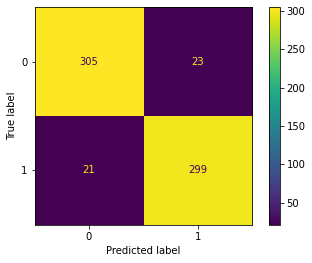

In [12]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

                    XGBClassifier

Train Score:   0.9861111111111112
Test Score:    0.9537037037037037

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       328
           1       0.92      0.99      0.95       320

    accuracy                           0.95       648
   macro avg       0.96      0.95      0.95       648
weighted avg       0.96      0.95      0.95       648



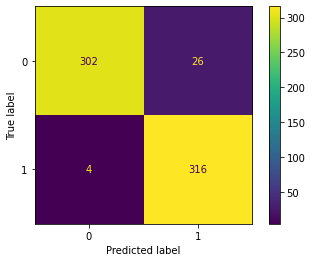

In [13]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

In [14]:
def kmeans_clus(df,not_x,not_y,k,cluster_label):
    df=df.copy()
    centroids,distortions=kmeans(df[[not_x,not_y]],k_or_guess=k)
    labels,_=vq(df[[not_x,not_y]],centroids)
    df[cluster_label]=labels
    sns.scatterplot(x=not_x,y=not_y,data=df,hue=cluster_label)
    for i in range(k):
        plt.scatter(x=centroids[i,0],y=centroids[i,1],s=500,cmap='Cyan')

In [15]:
pca=PCA(random_state=44)
pc=pca.fit_transform(df.drop('Class',axis=1))
len(pc[0])
pc_x,pc_y='pc_x','pc_y'
df[pc_x]=pc[:,0]
df[pc_y]=pc[:,1]

In [16]:
x=df[[pc_x,pc_y]]
y=df[['Class']].values
x_train,x_test,y_train,y_test=over_sample_train_test(x,y)

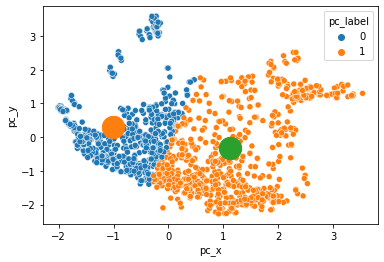

In [17]:
kmeans_clus(df,pc_x,pc_y,2,'pc_label')

                    XGBClassifier

Train Score:   0.9868827160493827
Test Score:    0.9629629629629629

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       328
           1       0.93      1.00      0.96       320

    accuracy                           0.96       648
   macro avg       0.97      0.96      0.96       648
weighted avg       0.97      0.96      0.96       648



ValueError: Feature shape mismatch, expected: 2, got 1558

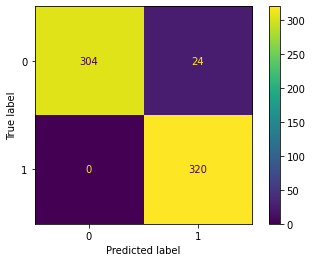

In [18]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

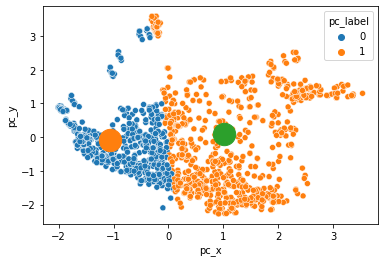

In [19]:
kmeans_clus(df,pc_x,pc_y,2,'pc_label')

In [23]:
y.shape

(1763, 1)